# Modeling of DA clamping
# Shun Li, 2024/09/17

"""
DA: discrete events convolved by a response kernel (will be replaced by actual measurement)
LHb: discrete events convolved by a kernel (will be replaced by actual measurement)
Baseline photobleaching
"""


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


In [7]:
import matplotlib.colors as mcolors

def plot_sem(y, x=None, 
            label=None, color=None, ax=None, alpha=None, 
            fill=True,
            plot_individual=False):

    n_events, n_timepoints = y.shape

    if x is None:
        x = np.arange(n_timepoints)
    
    if ax is None:
        ax = plt.gca()
    if color is None:
        color = ax._get_lines.get_next_color()

    # Make color more transparent based on alpha values
    # If color is a string or tuple, convert to RGBA and apply alpha if given
    if alpha is not None:
        try:
            base_color = mcolors.to_rgba(color)
            color = (base_color[0], base_color[1], base_color[2], alpha)
        except Exception:
            # fallback: if color cannot be converted, just use as is
            pass

    norm = mcolors.Normalize(vmin=0, vmax=len(y))

    mean = np.nanmean(y, axis=0)
    sem  = np.nanstd(y, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(y), axis=0))
    ax.plot(x, mean, color=color, label=label)
    
    if fill: ax.fill_between(x, mean - sem, mean + sem, alpha=0.2, color=color, edgecolor='None', label="_nolegend_")

    if plot_individual:
        for i, trace in enumerate(y):
            ax.plot(x, trace, linewidth=0.5, color=color, alpha=0.2, label="_nolegend_")

In [9]:
def get_traces(data, event, pre_steps, post_steps):
    data = np.asarray(data)
    T    = data.shape[0]

    if len(data) == len(event):
        event_idx = np.where(np.diff(event) == 1)[0] + 1
    else:
        event_idx = np.asarray(event, dtype=int)

    n_trials   = len(event_idx)
    window_len = pre_steps + post_steps + 1

    aligned_data = np.zeros((n_trials, window_len), dtype=data.dtype)

    for i, idx in enumerate(event_idx):
        start = idx - pre_steps
        end   = idx + post_steps
        lo = max(start, 0)
        hi = min(end, T - 1)
        w_lo = lo - start
        w_hi = w_lo + (hi - lo) + 1
        aligned_data[i, w_lo : w_hi] = data[lo : hi + 1]

    return aligned_data

## Simulate a sample period of DA recording


In [2]:
# Parameters
Kon = 8
Koff = 111
Fs = 200  # Hz
Kon_samples = (Kon/(1-1/np.exp(1))) / ((1/Fs)*1000)
Koff_samples = (Koff/(1-1/np.exp(1))) / ((1/Fs)*1000)
kernelLength = np.arange(0, 100)  # duration of single event response in samples
color = [0.3, 0.8, 0.6]

# Reward kernel
reward_kernel = -np.exp(-kernelLength/Kon) * (1 - np.exp(kernelLength/Koff))  # single event response
# reward_kernel = -np.exp(-kernelLength/Kon) + np.exp(-kernelLength/Koff)

# Generate reward channel (Poisson process)
reward_channel = np.random.rand(1, Fs*2000) < 0.001
rewardIdx = np.where(reward_channel[0])[0]

print(f"Number of reward events: {len(rewardIdx)}")
print(f"Reward kernel length: {len(reward_kernel)}")
print(f"Reward channel length: {len(reward_channel[0])}")


Number of reward events: 384
Reward kernel length: 100
Reward channel length: 400000


In [3]:
# Get ground truth DA signal
trueDA = np.convolve(reward_kernel, reward_channel[0], mode='full')
recordLength = len(trueDA)

# Model noise
noise = np.diff(0.03 * np.random.rand(2, recordLength), axis=0)[0]

# Model baseline photobleaching
baseline = 1 + 0.5 * (np.exp(-0.00001 * np.arange(1, recordLength + 1)))

# Get final signal
signal_data = trueDA + noise + baseline

print(f"True DA length: {len(trueDA)}")
print(f"Noise length: {len(noise)}")
print(f"Baseline length: {len(baseline)}")
print(f"Final signal length: {len(signal_data)}")


True DA length: 400099
Noise length: 400099
Baseline length: 400099
Final signal length: 400099


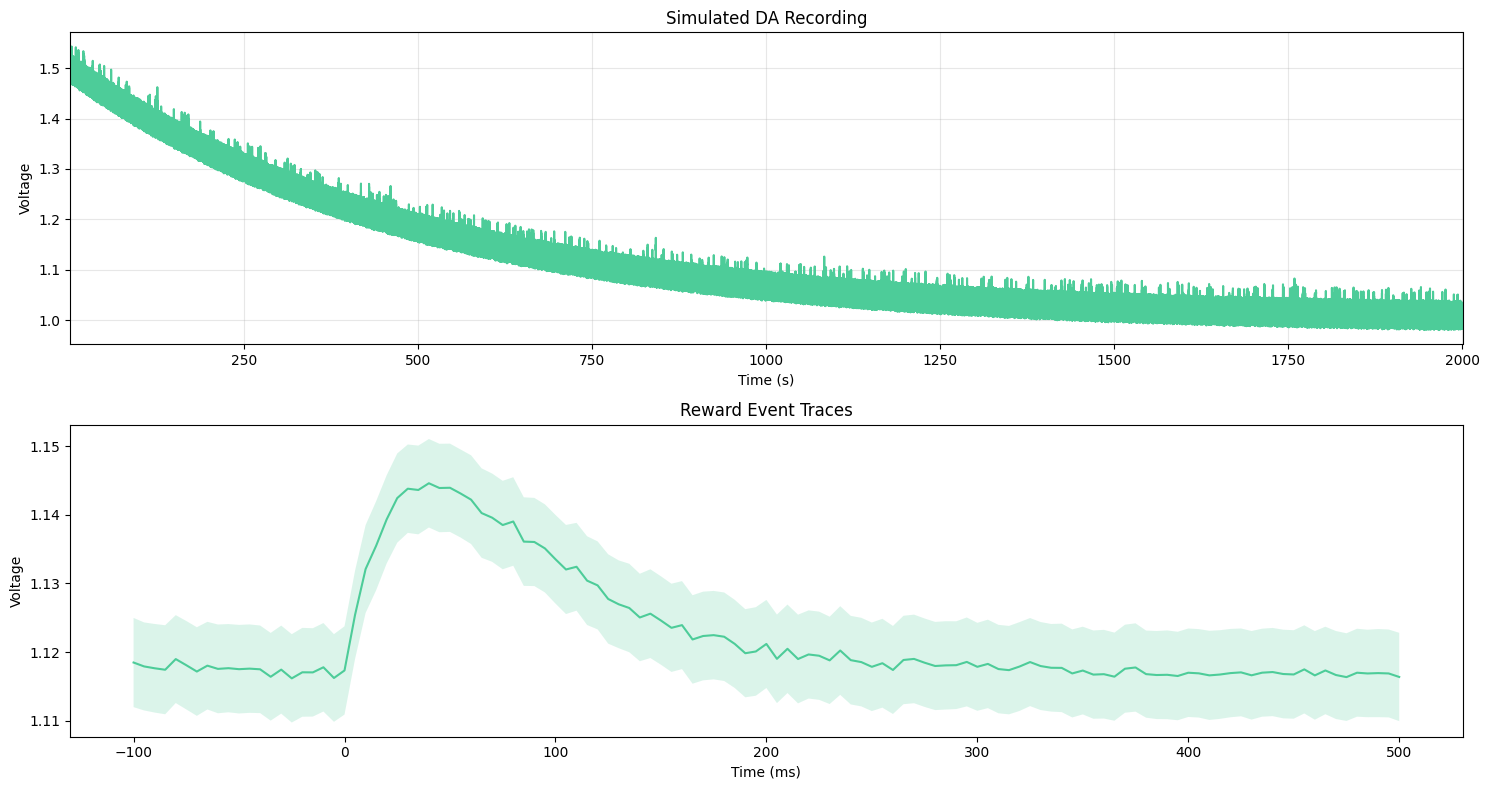

In [23]:
# Plot the simulated DA recording
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Top plot: Full signal
ax1.set_title('Simulated DA Recording')
time = np.arange(len(signal_data)) / Fs
ax1.plot(time, signal_data, color=color)
ax1.set_xlabel('Time (s)')
ax1.set_xlim([1, 2000])
ax1.set_ylabel('Voltage')
ax1.grid(True, alpha=0.3)

# Bottom plot: Reward event traces
ax2.set_title('Reward Event Traces')
pre_steps = 20
post_steps = 100
time_aligned = np.arange(-pre_steps, post_steps+1) * 1000/Fs
reward_traces = get_traces(signal_data, rewardIdx, pre_steps, post_steps)
plot_sem(reward_traces, x=time_aligned, label='Reward', color=color)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Voltage')

plt.tight_layout()
plt.show()


## Simulated PID Controller


In [57]:
def lowpass_filter(input_data, cutoff_freq, fs):
    nyquist_freq = 0.5 * fs
    normalized_cutoff = cutoff_freq / nyquist_freq
    b, a = signal.butter(4, normalized_cutoff, btype='low', analog=False)
    return signal.filtfilt(b, a, input_data)

In [118]:
def run_pid_simulation(
    signal_data,
    baseline,
    Fs=200,
    kernelLength=np.arange(0, 100),
    Kon=8,
    Koff=111,
    Kp=5000,
    Ki=10,
    Kd=60,
    f_pwm=980
):
    """
    Runs a PID simulation on the input signal data.

    Args:
        signal_data (np.ndarray): Input signal.
        baseline (float or np.ndarray): Target baseline value or signal.
        Fs (float): Sampling frequency.
        kernelLength (np.ndarray or float): Kernel length array or value.
        Kon (float): On time constant.
        Koff (float): Off time constant.
        Kp (float): Proportional gain for PID (default=5000).
        Ki (float): Integral gain for PID (default=10).
        Kd (float): Derivative gain for PID (default=60).
        f_pwm (float): PWM frequency (default=980Hz).

    Returns:
        dict: A dictionary with keys:
            - input_data: lowpass filtered input
            - target_data: target baseline
            - t: time vector
            - output_data: PID (raw) output in [0,255]
            - duty_cycle: PID output mapped to duty cycle [0,100]
            - pwm_signal: simulated PWM (0 or 1)
            - feedback: feedback DA signal from convolved PWM
            - clamped_signal: summed signal after feedback
            - stim_kernel: stimulation kernel
    """
    # Initialize input and target vectors
    input_data = lowpass_filter(signal_data, 20, Fs)
    target_data = baseline

    print(f"PID gains - Kp: {Kp}, Ki: {Ki}, Kd: {Kd}")

    # Time step
    fs = 200
    dt = 1/fs
    N = len(input_data)  # Number of data points
    t = np.arange(N) * dt  # Time vector

    integral_term = 0
    previous_error = 0
    output_data = np.zeros(N)

    # PID calculation
    for i in range(N):
        # Calculate the error
        error = input_data[i] - target_data[i]

        # Compute the Proportional, Integral, and Derivative terms
        P = Kp * error
        integral_term = integral_term + error * dt
        I = Ki * integral_term
        derivative_term = error - previous_error if i > 0 else 0 # proportional to measurement
        D = Kd * derivative_term

        # Calculate the PID output
        output_data[i] = P + I + D

        # Update the previous error for the next iteration
        previous_error = error

    # Map output signal (0 to 255) to duty cycle (0% to 100%)
    output_data = np.clip(output_data, 0, 255)
    duty_cycle = (output_data / 255) * 100

    # Generate the PWM signal based on duty cycle
    pwm_signal = np.zeros(len(t))
    for i in range(len(t)):
        # Create square wave based on duty cycle
        period = 1 / f_pwm
        phase = (t[i] % period) / period
        if phase < (duty_cycle[i] / 100):
            pwm_signal[i] = 1
        else:
            pwm_signal[i] = 0

    # Add controller input back to true DA
    stim_kernel = 0.15 * np.exp(-kernelLength/Kon) * (1 - np.exp(kernelLength/Koff))
    stim_channel = pwm_signal
    stimIdx = np.where(stim_channel < -0.5)[0]
    feedback = np.convolve(stim_channel, stim_kernel, mode='same')

    clamped_signal = input_data + feedback

    return {
        "input_data": input_data,
        "target_data": target_data,
        "t": t,
        "output_data": output_data,
        "duty_cycle": duty_cycle,
        "pwm_signal": pwm_signal,
        "feedback": feedback,
        "clamped_signal": clamped_signal,
        "stim_kernel": stim_kernel,
        "stimIdx": stimIdx
    }

PID gains - Kp: 5000, Ki: 10, Kd: 60


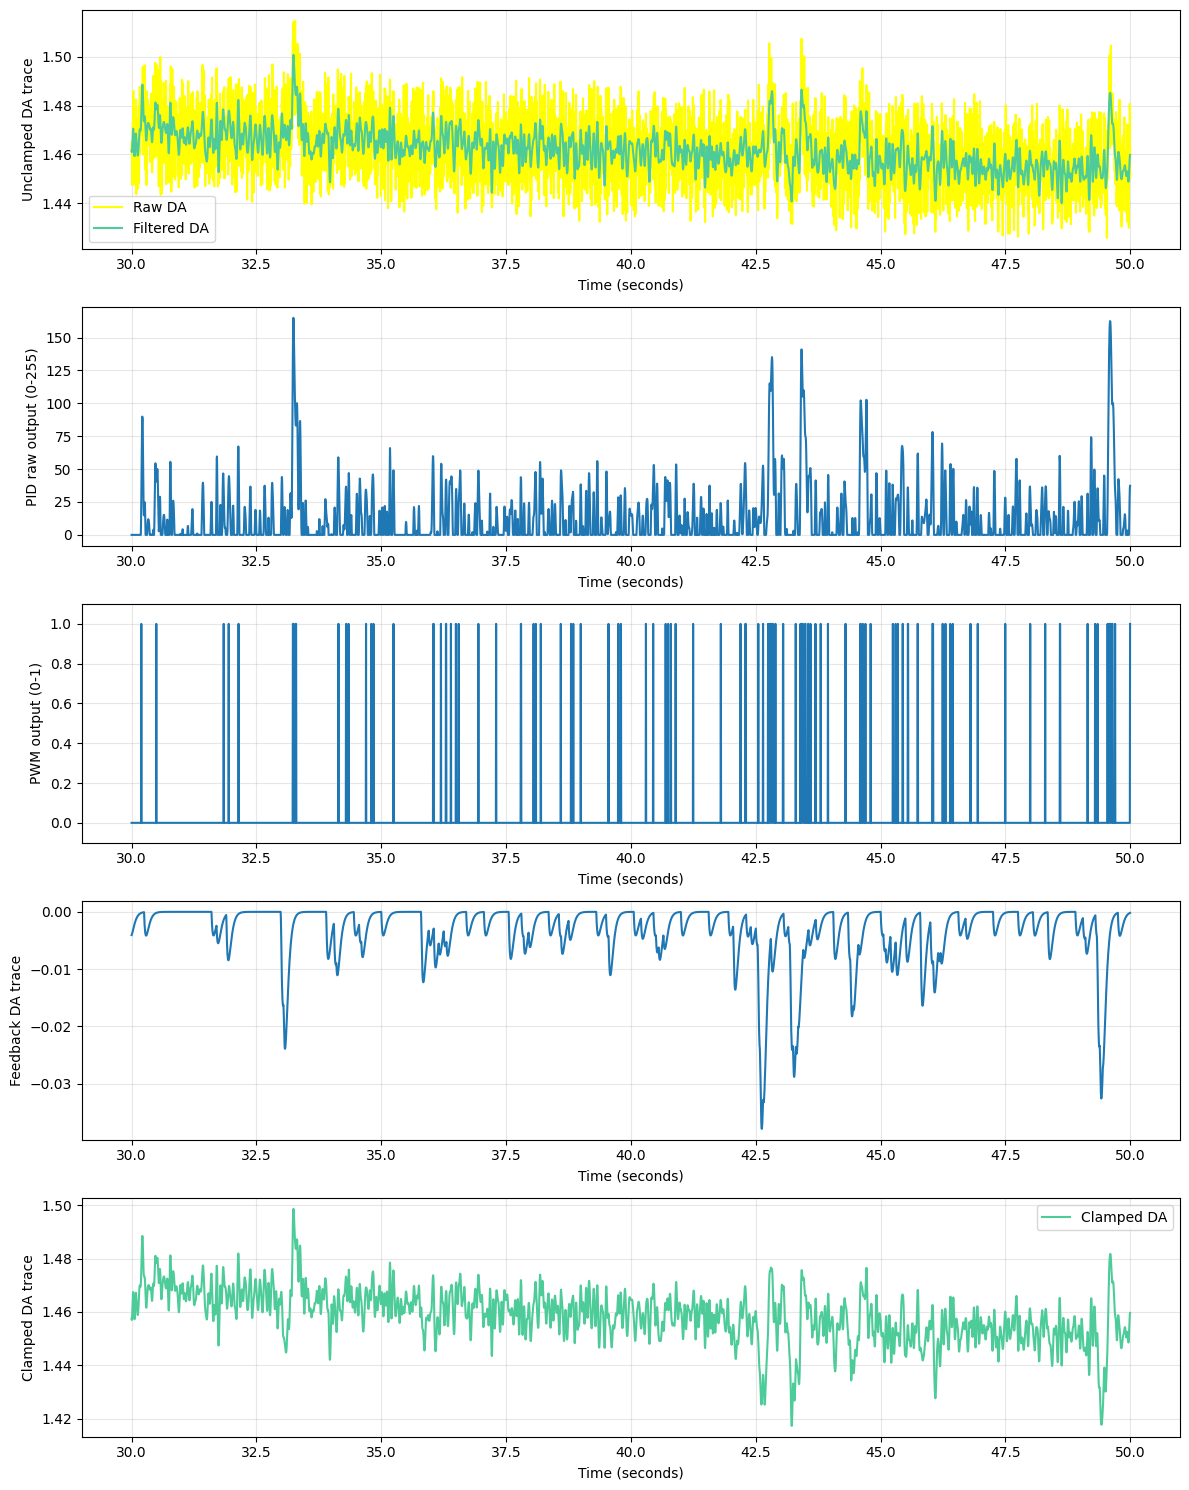

In [119]:
# Plot the PID results
fig, axes = plt.subplots(5, 1, figsize=(12, 15))

# Run the simulation
results = run_pid_simulation(signal_data, baseline, Kp=5000, Ki=10, Kd=60)
output_data = results["output_data"]
pwm_signal = results["pwm_signal"]
feedback = results["feedback"]
clamped_signal = results["clamped_signal"]

# Define time window for plotting
time_start, time_end = 30, 50
start_idx = int(time_start * Fs)
end_idx = int(time_end * Fs)

# Plot 1: Unclamped DA trace
axes[0].plot(t[start_idx:end_idx], signal_data[start_idx:end_idx], label='Raw DA', color='yellow')
axes[0].plot(t[start_idx:end_idx], lowpass_filter(signal_data, 20, Fs)[start_idx:end_idx], label='Filtered DA', color=color)
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Unclamped DA trace')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: PID duty cycle
axes[1].plot(t[start_idx:end_idx], output_data[start_idx:end_idx])
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('PID raw output (0-255)')
axes[1].grid(True, alpha=0.3)

# Plot 3: PWM output
axes[2].plot(t[start_idx:end_idx], pwm_signal[start_idx:end_idx])
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('PWM output (0-1)')
axes[2].set_ylim([-0.1, 1.1])
axes[2].grid(True, alpha=0.3)

# Plot 4: Feedback DA trace
axes[3].plot(t[start_idx:end_idx], feedback[start_idx:end_idx])
axes[3].set_xlabel('Time (seconds)')
axes[3].set_ylabel('Feedback DA trace')
axes[3].grid(True, alpha=0.3)

# Plot 5: Clamped DA trace
axes[4].plot(t[start_idx:end_idx], clamped_signal[start_idx:end_idx], color=color, label='Clamped DA')
axes[4].set_xlabel('Time (seconds)')
axes[4].set_ylabel('Clamped DA trace')
axes[4].legend()
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## How Convolution Works


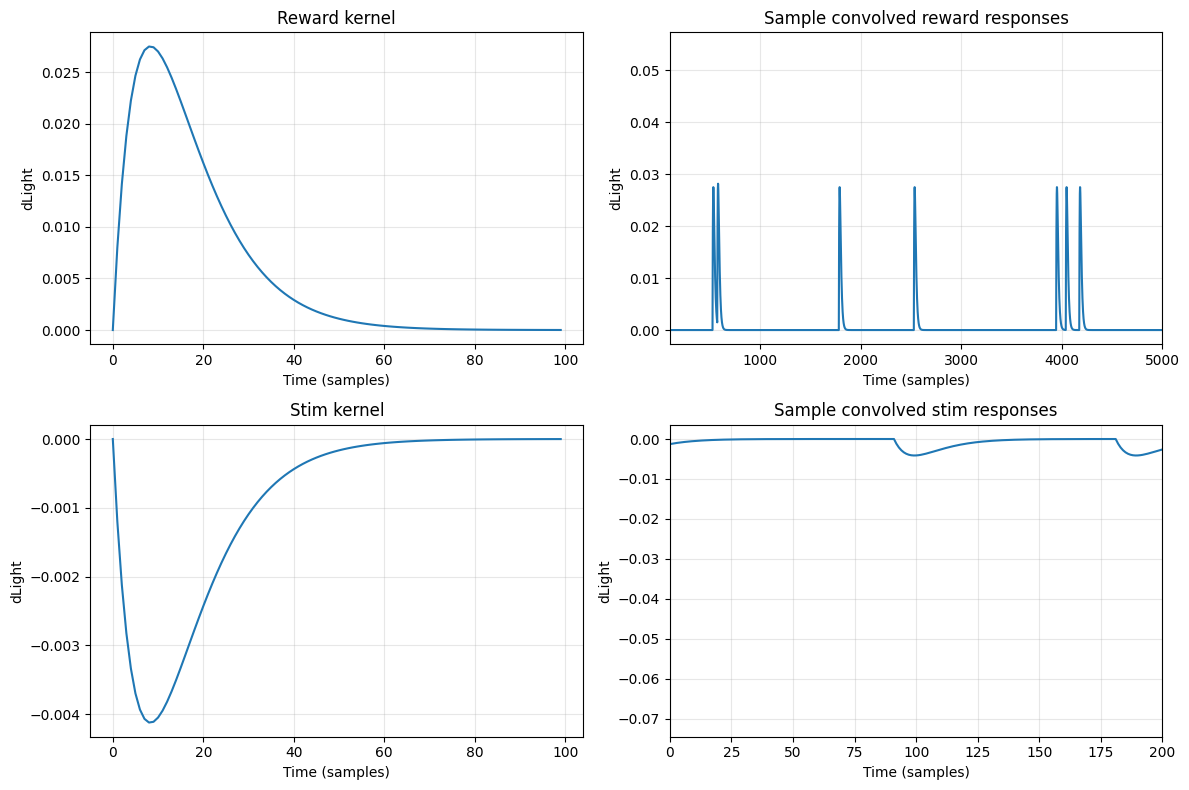

In [102]:
# Plot convolution examples
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1: Reward kernel
axes[0, 0].plot(reward_kernel)
axes[0, 0].set_xlabel('Time (samples)')
axes[0, 0].set_ylabel('dLight')
axes[0, 0].set_title('Reward kernel')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Sample convolved reward responses
axes[0, 1].plot(trueDA)
axes[0, 1].set_xlim([100, 5000])
axes[0, 1].set_xlabel('Time (samples)')
axes[0, 1].set_ylabel('dLight')
axes[0, 1].set_title('Sample convolved reward responses')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Stim kernel
axes[1, 0].plot(stim_kernel)
axes[1, 0].set_xlabel('Time (samples)')
axes[1, 0].set_ylabel('dLight')
axes[1, 0].set_title('Stim kernel')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Sample convolved stim responses
axes[1, 1].plot(feedback)
axes[1, 1].set_xlim([0, 200])
axes[1, 1].set_xlabel('Time (samples)')
axes[1, 1].set_ylabel('dLight')
axes[1, 1].set_title('Sample convolved stim responses')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## PID Gain Optimization


In [120]:
from scipy.optimize import minimize
import time

def simulate_pid_clamp(gains, input_signal, target_signal):
    """
    Calculate PID clamping performance given gains [Kp, Ki, Kd]
    Returns the mean squared error between clamped signal and target
    """
    results = run_pid_simulation(input_signal, target_signal, Kp=gains[0], Ki=gains[1], Kd=gains[2])
    clamped_signal = results["clamped_signal"]
    
    # Performance metric: Mean Squared Error
    mse = np.mean((clamped_signal - target_signal)**2)
    
    return mse


In [129]:
# Define optimization parameters
initial_gains = [50, 0, 0]  # [Kp, Ki, Kd] - start with original values
bounds = [(1, 10000), (0, 1000), (0, 10000)]  # [Kp bounds, Ki bounds, Kd bounds]

# Use a shorter signal for faster optimization (first 10 seconds)
optimization_length = 2000 * Fs  # 10 seconds
input_opt = lowpass_filter(signal_data[:optimization_length], 20, Fs)
target_opt = baseline[:optimization_length]

print(f"Optimizing PID gains using {optimization_length} samples ({optimization_length/fs:.1f} seconds)")
print(f"Initial gains: Kp={initial_gains[0]}, Ki={initial_gains[1]}, Kd={initial_gains[2]}")
print(f"Bounds: Kp={bounds[0]}, Ki={bounds[1]}, Kd={bounds[2]}")


Optimizing PID gains using 400000 samples (2000.0 seconds)
Initial gains: Kp=50, Ki=0, Kd=0
Bounds: Kp=(1, 10000), Ki=(0, 1000), Kd=(0, 10000)


In [131]:
# Test the function first to make sure it works
print("Testing the optimization function...")
test_mse = simulate_pid_clamp(initial_gains, input_opt, target_opt)
print(f"Initial MSE with test gains: {test_mse:.6f}")

# Try different initial guesses to see if we can find improvement
test_gains = [
    [10, 0, 0],    # Lower Kp
    [5000, 0, 1000],   # Higher Kp  
    [50, 10, 0],   # Add some Ki
    [50, 0, 10],   # Add some Kd
    [30, 5, 5],    # Balanced gains
]

print("\nTesting different gain combinations:")
for i, gains in enumerate(test_gains):
    try:
        mse = simulate_pid_clamp(gains, input_opt, target_opt)
        print(f"Gains {gains}: MSE = {mse:.6f}")
    except Exception as e:
        print(f"Gains {gains}: Error - {e}")

# Run optimization with more relaxed bounds
print(f"\nStarting PID gain optimization...")
print(f"Initial gains: {initial_gains}")
print(f"Bounds: {bounds}")

start_time = time.time()

# Use L-BFGS-B method for bounded optimization
result = minimize(
    fun=simulate_pid_clamp,
    x0=initial_gains,
    args=(input_opt, target_opt),
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 200, 'disp': True}
)

optimization_time = time.time() - start_time

print(f"\nOptimization completed in {optimization_time:.2f} seconds")
print(f"Success: {result.success}")
print(f"Number of iterations: {result.nit}")
print(f"Number of function evaluations: {result.nfev}")

# Extract optimal gains
optimal_gains = result.x
Kp_opt, Ki_opt, Kd_opt = optimal_gains

print(f"\nOptimal PID gains:")
print(f"Kp = {Kp_opt:.2f}")
print(f"Ki = {Ki_opt:.2f}")
print(f"Kd = {Kd_opt:.2f}")

# Calculate performance improvement
initial_mse = simulate_pid_clamp(initial_gains, input_opt, target_opt)
optimal_mse = result.fun
improvement = ((initial_mse - optimal_mse) / initial_mse) * 100

print(f"\nPerformance improvement:")
print(f"Initial MSE: {initial_mse:.6f}")
print(f"Optimal MSE: {optimal_mse:.6f}")
print(f"Improvement: {improvement:.1f}%")


Testing the optimization function...
PID gains - Kp: 50, Ki: 0, Kd: 0
Initial MSE with test gains: 0.000036

Testing different gain combinations:
PID gains - Kp: 10, Ki: 0, Kd: 0
Gains [10, 0, 0]: MSE = 0.000036
PID gains - Kp: 5000, Ki: 0, Kd: 1000
Gains [5000, 0, 1000]: MSE = 0.000058
PID gains - Kp: 50, Ki: 10, Kd: 0
Gains [50, 10, 0]: MSE = 0.000037
PID gains - Kp: 50, Ki: 0, Kd: 10
Gains [50, 0, 10]: MSE = 0.000036
PID gains - Kp: 30, Ki: 5, Kd: 5
Gains [30, 5, 5]: MSE = 0.000037

Starting PID gain optimization...
Initial gains: [50, 0, 0]
Bounds: [(1, 10000), (0, 1000), (0, 10000)]
PID gains - Kp: 50.0, Ki: 0.0, Kd: 0.0
PID gains - Kp: 50.00000001, Ki: 0.0, Kd: 0.0
PID gains - Kp: 50.0, Ki: 1e-08, Kd: 0.0
PID gains - Kp: 50.0, Ki: 0.0, Kd: 1e-08

Optimization completed in 1.33 seconds
Success: True
Number of iterations: 0
Number of function evaluations: 4

Optimal PID gains:
Kp = 50.00
Ki = 0.00
Kd = 0.00
PID gains - Kp: 50, Ki: 0, Kd: 0

Performance improvement:
Initial MSE: 0.0

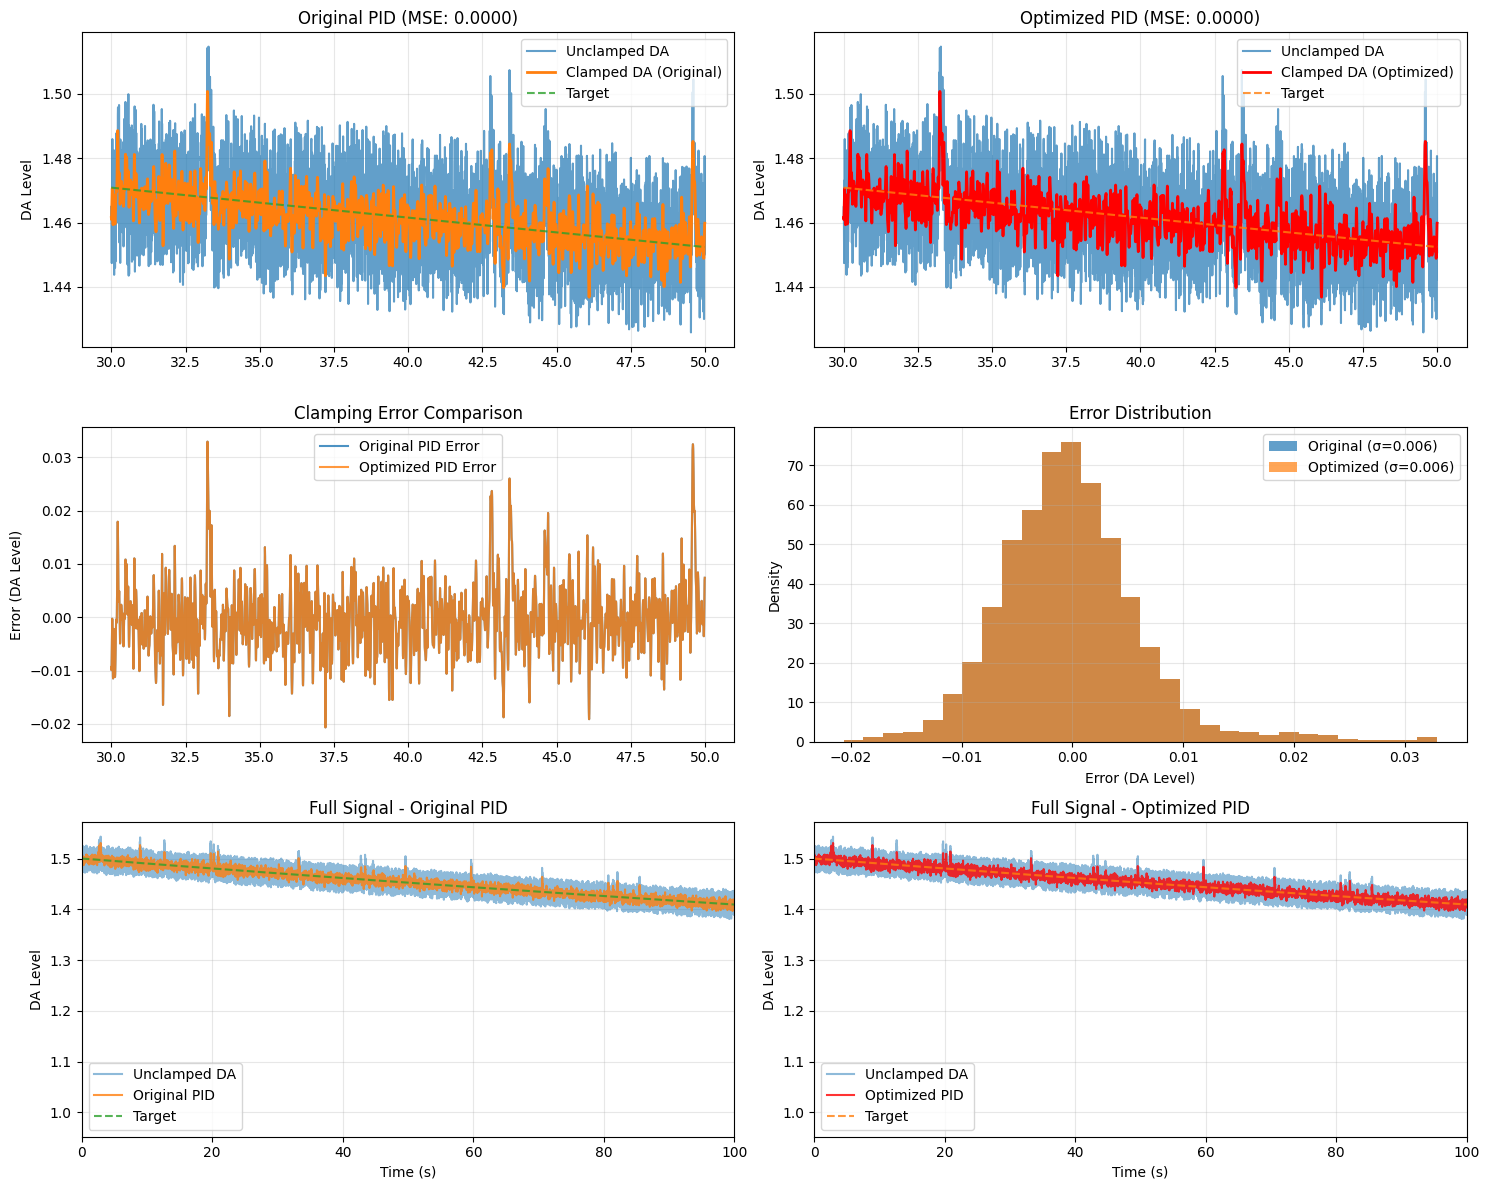

In [ ]:
# Compare original vs optimized PID performance

# Run simulations
print("Running simulations with original and optimized gains...")
original_results = run_pid_simulation(signal_data, baseline, Kp=initial_gains[0], Ki=initial_gains[1], Kd=initial_gains[2])
optimized_results = run_pid_simulation(signal_data, baseline, Kp=optimal_gains[0], Ki=optimal_gains[1], Kd=optimal_gains[2])

print("Simulations completed.")

# Plot comparison of original vs optimized PID performance
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Define time window for detailed comparison
time_start, time_end = 30, 50
start_idx = int(time_start * Fs)
end_idx = int(time_end * Fs)

# Get the results
original_signal = original_results["clamped_signal"]
optimized_signal = optimized_results["clamped_signal"]
t = original_results["t"]

# Calculate MSE for the comparison window
original_mse_window = np.mean((original_signal[start_idx:end_idx] - baseline[start_idx:end_idx])**2)
optimized_mse_window = np.mean((optimized_signal[start_idx:end_idx] - baseline[start_idx:end_idx])**2)

# Plot 1: Original PID - Unclamped vs Clamped vs Target
axes[0, 0].plot(t[start_idx:end_idx], signal_data[start_idx:end_idx], label='Unclamped DA', alpha=0.7)
axes[0, 0].plot(t[start_idx:end_idx], original_signal[start_idx:end_idx], label='Clamped DA (Original)', linewidth=2)
axes[0, 0].plot(t[start_idx:end_idx], baseline[start_idx:end_idx], label='Target', linestyle='--', alpha=0.8)
axes[0, 0].set_title(f'Original PID (MSE: {original_mse_window:.4f})')
axes[0, 0].set_ylabel('DA Level')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Optimized PID - Unclamped vs Clamped vs Target
axes[0, 1].plot(t[start_idx:end_idx], signal_data[start_idx:end_idx], label='Unclamped DA', alpha=0.7)
axes[0, 1].plot(t[start_idx:end_idx], optimized_signal[start_idx:end_idx], label='Clamped DA (Optimized)', linewidth=2, color='red')
axes[0, 1].plot(t[start_idx:end_idx], baseline[start_idx:end_idx], label='Target', linestyle='--', alpha=0.8)
axes[0, 1].set_title(f'Optimized PID (MSE: {optimized_mse_window:.4f})')
axes[0, 1].set_ylabel('DA Level')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Error comparison
error_original = original_signal[start_idx:end_idx] - baseline[start_idx:end_idx]
error_optimized = optimized_signal[start_idx:end_idx] - baseline[start_idx:end_idx]

axes[1, 0].plot(t[start_idx:end_idx], error_original, label='Original PID Error', alpha=0.8)
axes[1, 0].plot(t[start_idx:end_idx], error_optimized, label='Optimized PID Error', alpha=0.8)
axes[1, 0].set_title('Clamping Error Comparison')
axes[1, 0].set_ylabel('Error (DA Level)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Error distributions
axes[1, 1].hist(error_original, bins=30, alpha=0.7, label=f'Original (σ={np.std(error_original):.3f})', density=True)
axes[1, 1].hist(error_optimized, bins=30, alpha=0.7, label=f'Optimized (σ={np.std(error_optimized):.3f})', density=True)
axes[1, 1].set_title('Error Distribution')
axes[1, 1].set_xlabel('Error (DA Level)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: Full signal comparison (zoomed out)
axes[2, 0].plot(t, signal_data, label='Unclamped DA', alpha=0.5)
axes[2, 0].plot(t, original_signal, label='Original PID', alpha=0.8)
axes[2, 0].plot(t, baseline, label='Target', linestyle='--', alpha=0.8)
axes[2, 0].set_title('Full Signal - Original PID')
axes[2, 0].set_xlabel('Time (s)')
axes[2, 0].set_ylabel('DA Level')
axes[2, 0].set_xlim([0, 100])
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Full signal comparison (zoomed out)
axes[2, 1].plot(t, signal_data, label='Unclamped DA', alpha=0.5)
axes[2, 1].plot(t, optimized_signal, label='Optimized PID', alpha=0.8, color='red')
axes[2, 1].plot(t, baseline, label='Target', linestyle='--', alpha=0.8)
axes[2, 1].set_title('Full Signal - Optimized PID')
axes[2, 1].set_xlabel('Time (s)')
axes[2, 1].set_ylabel('DA Level')
axes[2, 1].set_xlim([0, 100])
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
